# Revisiting logistic regression 

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import mscl.plotting
import pymc3 as pm
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import pystan as stan
colors = mscl.plotting.set_plotting_style()
import imp
import mscl.mcmc
imp.reload(mscl.mcmc)
%matplotlib inline

##  The problem

Up to this point,I've always performed the logistic regression by fitting a coefficient for the predictor variable (effective channel number) as well as a coefficient for the probability of survival with zero channels. While this is okay without any prior knowledge, we *know* that there is such a low probability of survival that it is effectively negligible.

Here, I will try to perform the logistic regression forcing the channel free survival probability be to be zero.

##  Loading and validating the data.

In [2]:
# Load the data. 
data = pd.read_csv('../data/csv/compiled_data.csv')

# Isolate shock clas and split into flow rate. 
shock_data = data[data['class'] == 'shock'].copy()
a = list(shock_data['survival'].values)
c = list(shock_data['chan_per_cell'].values)
for i in range(5000):
    p = np.random.rand()
    if p < 1e-3:
        a.append(1)
    else:
        a.append(0)
    c.append(0)
    
# add an identifier for fast or slow. 
idx_val = np.zeros(len(shock_data))
for i in range(len(shock_data)):
    if shock_data.iloc[i]['flow_rate'] >= 1.0:
        idx_val[i] = 1
shock_data['flow_class'] = idx_val
slow = shock_data[shock_data['flow_rate'] < 1.0]
fast = shock_data[shock_data['flow_rate'] >= 1.0 ]

In [10]:
model = """
data {
    int<lower=0> N;
    int<lower=0, upper=1> survival[N];
    vector<lower=0>[N] num_channel;
    vector<lower=0>[N] channel_err;
    }

parameters {
    real beta;
    real alpha;
    vector<lower=0>[N] channel;
    }

model {
    alpha ~ normal(0, 100);
    beta ~ normal(0, 100);
    channel ~ normal(num_channel, channel_err);
    survival ~ bernoulli_logit(alpha + beta * channel);
    }
"""
sm = stan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f657af2063a9318f1f5686726b4b43cf NOW.


In [15]:
survival = list(fast['survival'].values.astype(int))
channel = list(fast['chan_per_cell'].values)
channel_sig = list(fast['chan_per_cell'].values * 0.13)
for i in range(500):
    survival.append(0)
    channel.append(0)
    channel_sig.append(1E-9)
N = len(survival)   
dat = {'N':N, 'survival':survival, 'num_channel':channel, 'channel_err':channel_sig}
fit = sm.sampling(data=dat, iter=2000, chains=4)

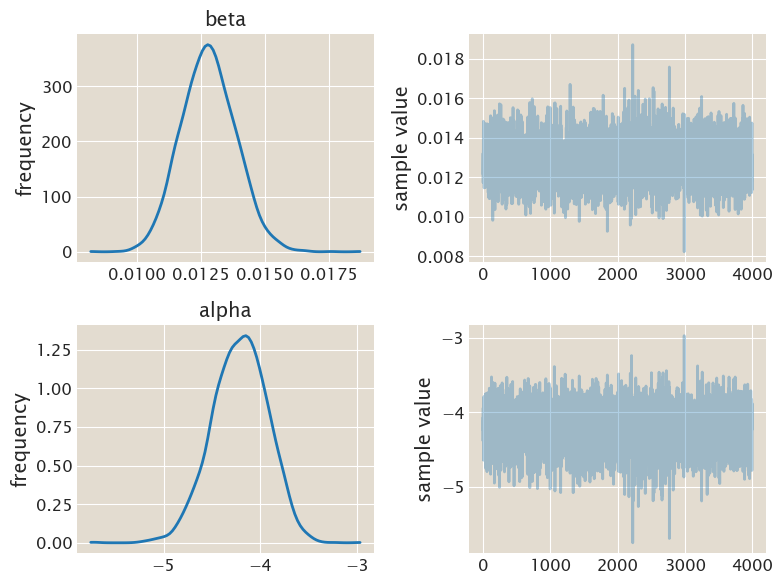

In [20]:
_ = fit.plot(pars=['beta', 'alpha'])
plt.tight_layout()

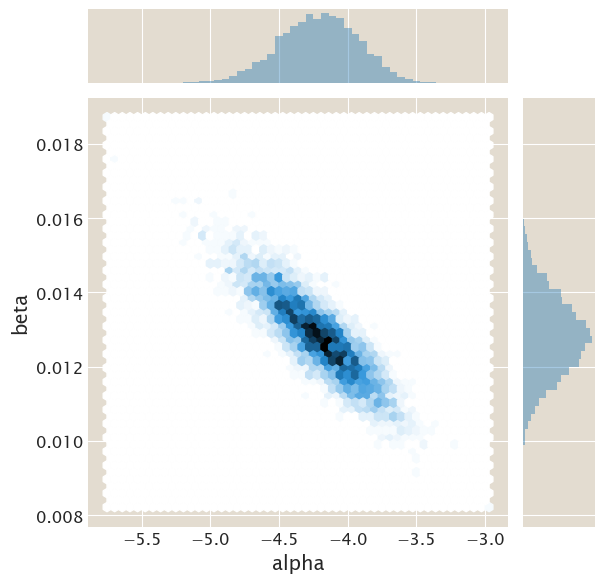

In [103]:

sns.jointplot(out_df['alpha'], out_df['beta'], kind='hex', stat_func=None)


In [102]:
sns.jointplot?